In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score

from seiz_eeg.dataset import EEGDataset

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [2]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "../data"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# Split the dataset by the 'patient' column
patients = clips_tr['signals_path'].unique()
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42)

# Create training and validation datasets
train_clips = clips_tr[clips_tr['signals_path'].isin(train_patients)]
val_clips = clips_tr[clips_tr['signals_path'].isin(val_patients)]

## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [ ]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)

def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain and downsample it"""
    x = signal.sosfiltfilt(bp_filter, x, axis=0).copy()
    return x[::4]  # Downsample by factor of 4 (250 Hz → 62.5 Hz)



def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [4]:
# Dependences
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [5]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [6]:
train_dataset = EEGDataset(
        train_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=fft_filtering,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

val_dataset = EEGDataset(
        val_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=fft_filtering,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

loader_tr = DataLoader(
        dataset=train_dataset,
        shuffle=True,
        batch_size=512,
    )

loader_val = DataLoader(
        dataset=val_dataset,
        shuffle=True,
        batch_size=512,
    )

In [7]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Adjacency Matrix Construction for DCRNN

This section constructs the adjacency matrices required for the Diffusion Convolutional Recurrent Neural Network (DCRNN), which relies on graph-based signal propagation.

Steps:
1. Load 3D distance matrix: A 19×19 matrix is loaded from a CSV file, representing pairwise Euclidean distances between EEG channels.
2. Apply a Gaussian kernel: The adjacency matrix is computed by applying a Gaussian kernel to the distances, where closer nodes have stronger weights. The bandwidth `σ` is set as the standard deviation of all non-zero distances.
3. Sparsification: To reduce noise and computational cost, long-range connections (distances above the 75th percentile) are set to zero.
4. Graph normalization:
   - Two directed diffusion matrices are computed: `A_forward` for forward diffusion and `A_backward` for backward diffusion.
   - These are calculated using normalized graph Laplacians:  
     - `A_forward = D_out⁻¹ * W`
     - `A_backward = D_in⁻¹ * Wᵗ`

5. Conversion to PyTorch: Both matrices are converted to PyTorch tensors and moved to the selected device.

These matrices define the graph structure over which the DCRNN operates, enabling temporal and spatial learning across EEG electrodes.


In [8]:
adj = np.genfromtxt('./data/distances_3d.csv', skip_header=1, delimiter=',')[:, -1].reshape(19,19)
adj = torch.tensor(adj, dtype=torch.float32).to(device).unsqueeze(0)
print(adj.shape)

torch.Size([1, 19, 19])


In [9]:
# Load distance matrix (19x19)
dist_matrix = np.genfromtxt('./data/distances_3d.csv', skip_header=1, delimiter=',')[:, -1].reshape(19, 19)

# Gaussian kernel
sigma = np.std(dist_matrix[dist_matrix > 0])
adj = np.exp(-np.square(dist_matrix) / sigma**2)

# Sparsify: zero out long distances
threshold = np.percentile(dist_matrix[dist_matrix > 0], 75)
adj[dist_matrix > threshold] = 0

# Normalize to get forward and backward diffusion matrices
D_out = np.diag(adj.sum(axis=1))
D_in = np.diag(adj.sum(axis=0))

A_forward = np.linalg.inv(D_out) @ adj  # D_out⁻¹ * W
A_backward = np.linalg.inv(D_in) @ adj.T  # D_in⁻¹ * Wᵗ

# Convert to PyTorch
A_forward = torch.tensor(A_forward, dtype=torch.float32, device=device)
A_backward = torch.tensor(A_backward, dtype=torch.float32, device=device)

print("A_forward shape:", A_forward.shape)
print("A_backward shape:", A_backward.shape)


A_forward shape: torch.Size([19, 19])
A_backward shape: torch.Size([19, 19])


### Diffusion Convolution and Graph GRU Cell

This section defines the core components of the DCRNN architecture: the Diffusion Convolution layer and the DCGRU cell (Diffusion Convolutional Gated Recurrent Unit).

#### `DiffusionConv` Layer
This module implements spatial graph convolutions using diffusion processes over a directed graph:
- The input `x` has shape (B, N, in_channels), where `B` is batch size, and `N` is the number of nodes (e.g., EEG channels).
- `K` denotes the number of diffusion steps.
- For each step `k`, the input is propagated forward and backward using the normalized adjacency matrices `A_forward` and `A_backward`.
- The result of each step is transformed with learnable weights `θ_forward[k]` and `θ_backward[k]` and accumulated.
- The final output has shape (B, N, out_channels).

#### `DCGRUCell`
This is a custom GRU cell that replaces fully connected layers with `DiffusionConv`:
- Gating mechanism: The reset (`r`) and update (`u`) gates are computed from the concatenated input and hidden state using a diffusion convolution.
- Candidate state: Computed similarly, but using reset-modulated hidden state.
- Hidden state update: Follows standard GRU logic:  
  \[
  h_{t} = u \cdot h_{t-1} + (1 - u) \cdot \tilde{h}_{t}
  \]

By combining temporal recurrence with spatial diffusion over a graph, this setup allows learning both spatial dependencies across nodes and temporal patterns over time—crucial for EEG data structured over electrodes.


In [10]:

class DiffusionConv(nn.Module):
    def __init__(self, K, in_channels, out_channels): # K is the number of diffusion steps
        super().__init__()
        self.K = K
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.theta_forward = nn.Parameter(torch.FloatTensor(K, in_channels, out_channels))
        self.theta_backward = nn.Parameter(torch.FloatTensor(K, in_channels, out_channels))
        self.reset_parameters()

    def reset_parameters(self): # Initialize the parameters using Xavier initialization
        nn.init.xavier_uniform_(self.theta_forward)
        nn.init.xavier_uniform_(self.theta_backward)

    def forward(self, x, A_forward, A_backward):
        # x: (B, N, in_channels)
        out = 0
        x0 = x  # (B, N, in_channels)

        for k in range(self.K): #iterate over diffusion steps
            if k == 0: #initial step, no diffusion
                x_fw = x0
                x_bw = x0
            else: 
                x_fw = torch.einsum("ij,bjk->bik", A_forward, x_fw) 
                x_bw = torch.einsum("ij,bjk->bik", A_backward, x_bw)

            out += torch.einsum("bni,io->bno", x_fw, self.theta_forward[k])
            out += torch.einsum("bni,io->bno", x_bw, self.theta_backward[k])

        return out  # shape: (B, N, out_channels)

class DCGRUCell(nn.Module):
    def __init__(self, K, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.diff_conv_gate = DiffusionConv(K, input_dim + hidden_dim, 2 * hidden_dim)
        self.diff_conv_candidate = DiffusionConv(K, input_dim + hidden_dim, hidden_dim)

    def forward(self, x, h, A_forward, A_backward):
        # x, h: (B, N, input_dim/hidden_dim)
        xh = torch.cat([x, h], dim=-1)  # (B, N, input+hidden)
        gates = torch.sigmoid(self.diff_conv_gate(xh, A_forward, A_backward))
        r, u = torch.split(gates, self.hidden_dim, dim=-1)

        xh_candidate = torch.cat([x, r * h], dim=-1)
        c = torch.tanh(self.diff_conv_candidate(xh_candidate, A_forward, A_backward))

        h_new = u * h + (1 - u) * c
        return h_new


### DCRNN Model Architecture

This class defines the full **Diffusion Convolutional Recurrent Neural Network (DCRNN)** model, which combines spatial graph diffusion and temporal recurrence to process EEG time-series data structured over a graph of nodes (e.g., electrodes).

#### Components:
- **Input Dimensions**:
  - `B`: Batch size
  - `T`: Time steps
  - `N`: Number of nodes (e.g., 19 EEG channels)
  - `F`: Feature dimension per node (typically 1)

- **Stacked DCGRU layers**:
  - The model supports stacking multiple `DCGRUCell` layers via `rnn_cells`.
  - Each cell learns temporal dynamics and spatial interactions using the provided forward and backward adjacency matrices.

- **Hidden State**:
  - For each time step `t`, the model updates hidden states layer by layer.
  - Hidden states are initialized to zeros at the start of each sequence.

- **Output Layer**:
  - After processing the entire sequence, only the **final hidden state** from the top recurrent layer is used for prediction.
  - A linear layer maps this hidden state to the desired output dimension (e.g., binary classification).
  - The result is **averaged over all nodes**, producing a scalar prediction per sample.

This design allows the model to capture both **spatio-temporal dependencies** in EEG data and provides a principled way to incorporate graph structure into sequence modeling.


In [11]:
class DCRNN(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim, output_dim, K, A_forward, A_backward, num_layers=1):
        super().__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.A_forward = A_forward
        self.A_backward = A_backward

        # Stack multiple DCGRU layers
        self.rnn_cells = nn.ModuleList([
            DCGRUCell(K, input_dim if i == 0 else hidden_dim, hidden_dim)
            for i in range(num_layers)
        ])

        # Final linear layer to predict output from hidden state
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Ensure input has 4 dimensions: (B, T, N, F)
        if x.dim() == 3:
            x = x.unsqueeze(-1)

        B, T, N, F = x.shape
        h = [torch.zeros(B, N, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]

        for t in range(T):
            input_t = x[:, t]  # shape: (B, N, F)
            for i, cell in enumerate(self.rnn_cells):
                h[i] = cell(input_t, h[i], self.A_forward, self.A_backward)
                input_t = h[i]  # pass output to next layer

        # Use the final hidden state from the top layer
        out = self.output_layer(h[-1])  # shape: (B, N, output_dim)
        out = out.mean(dim=1)           # (B, 1)
        return out



### DCRNN Model Setup and Training Configuration

We instantiate the `DCRNN` model with parameters suited for EEG signal classification:

- Model Hyperparameters:
  - `num_nodes = 19`: Corresponds to the number of EEG electrodes.
  - `input_dim = 1`: One feature per node (e.g., raw amplitude).
  - `hidden_dim = 64`: Dimensionality of the GRU hidden state (tunable).
  - `output_dim = 1`: Scalar output for binary classification.
  - `K = 3`: Number of diffusion steps in the graph convolution (using 2 caused CUDA memory issues).
  - `num_layers = 1`: Single layer of DCGRU (can be increased if memory allows).

- Graph Matrices:
  The previously constructed `A_forward` and `A_backward` matrices are passed into the model to enable spatial diffusion across the EEG graph.

- Loss Function:
  A weighted binary cross-entropy loss (`BCEWithLogitsLoss`) is used to address class imbalance, with `pos_weight=4`.

- Optimizer:
  The model is trained using the Adam optimizer with a learning rate of `1e-3`.

- Model Size:
  The total number of trainable parameters is printed to provide insight into model complexity.

This setup is the starting point for training and can be fine-tuned further based on validation results or hardware constraints.


In [12]:
num_nodes = 19         # number of EEG electrodes
input_dim = 1          # e.g., 1 feature per channel (amplitude)
hidden_dim = 64        # arbitrary, tune this
output_dim = 1         # binary classification
K = 3                  # diffusion steps
#tried out 2, but CUDA had no memory left
num_layers = 1         # how many DCGRU layers

model = DCRNN(
    num_nodes=num_nodes,
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    K=K,
    A_forward=A_forward,
    A_backward=A_backward,
    num_layers=num_layers
).to(device)

# Loss function
class_weight = 4  # adjust depending on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [13]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters: {num_params}")


Number of model parameters: 74945


### Training and Evaluation of DCRNN

We train the `DCRNN` model for 10 epochs and evaluate its performance on a validation set after each epoch.

#### Training Loop:
- Input tensors are shaped to match model expectations: (B, T, N, 1) for input and (B, N, 1) for labels.
- The model outputs predictions per sample using `BCEWithLogitsLoss`, suitable for binary classification.
- After each batch, gradients are computed and weights updated using backpropagation and the Adam optimizer.
- Average training loss per epoch is recorded.

#### Validation Phase:
- The model is evaluated in inference mode (`model.eval()` with `torch.no_grad()`).
- Output logits are passed through a sigmoid to obtain probabilities.
- Probabilities are thresholded at 0.5 to get binary predictions.
- We track:
  - Validation loss
  - Macro F1 score
  - Macro Precision
  - Macro Recall

Metrics are averaged over all validation batches and reported per epoch.

#### Visualization:
- After training, loss and F1 scores are plotted across epochs to monitor learning progress and generalization.
- This provides insights into potential overfitting or underfitting trends.

This routine ensures both training dynamics and classification performance are thoroughly monitored.


In [ ]:
# Training setup
num_epochs = 10
train_losses, val_losses = [], []
val_f1_scores, val_precision_scores, val_recall_scores = [], [], []

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in loader_tr:
        x_batch = x_batch.float().unsqueeze(-1).to(device)  # (B, T, N, 1)
        y_batch = y_batch.float().unsqueeze(-1).to(device)  # (B, N, 1)

        # Forward pass
        logits = model(x_batch)  # shape: (B, N, 1)
        loss = criterion(logits, y_batch)  # now matches shape (B, 1)


        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(loader_tr))

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for x_val, y_val in loader_val:
            x_val = x_val.float().unsqueeze(-1).to(device)
            y_val = y_val.float().unsqueeze(-1).to(device)

            val_logits = model(x_val)
            val_probs = torch.sigmoid(val_logits)       # ← add this line
            val_preds = (val_probs > 0.5).int()         # ← now this works


            all_labels.extend(y_val.cpu().numpy().flatten())
            all_preds.extend(val_preds.cpu().numpy().flatten())

            val_loss = criterion(val_logits, y_val)
            val_running_loss += val_loss.item()

    val_losses.append(val_running_loss / len(loader_val))

    # Metrics
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    val_f1_scores.append(val_f1)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)

    print(f"Epoch {epoch+1}: F1 = {val_f1:.4f}, Precision = {val_precision:.4f}, Recall = {val_recall:.4f}")


Training:   0%|                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]

Training:  10%|███████████████▌                                                                                                                                           | 1/10 [00:45<06:48, 45.42s/it]

Epoch 1: F1 = 0.4508, Precision = 0.4106, Recall = 0.4998


Training:  20%|███████████████████████████████                                                                                                                            | 2/10 [01:28<05:53, 44.16s/it]

Epoch 2: F1 = 0.5847, Precision = 0.6295, Recall = 0.5740


Training:  30%|██████████████████████████████████████████████▌                                                                                                            | 3/10 [02:12<05:06, 43.85s/it]

Epoch 3: F1 = 0.6337, Precision = 0.6243, Recall = 0.6756


Training:  40%|██████████████████████████████████████████████████████████████                                                                                             | 4/10 [02:55<04:22, 43.73s/it]

Epoch 4: F1 = 0.4928, Precision = 0.6355, Recall = 0.5173


Training:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [03:39<03:37, 43.59s/it]

Epoch 5: F1 = 0.6467, Precision = 0.6367, Recall = 0.6644


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 6/10 [04:22<02:54, 43.57s/it]

Epoch 6: F1 = 0.6407, Precision = 0.6326, Recall = 0.6972


Training:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 7/10 [05:06<02:10, 43.55s/it]

Epoch 7: F1 = 0.6800, Precision = 0.6642, Recall = 0.7263


Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 8/10 [05:49<01:27, 43.57s/it]

Epoch 8: F1 = 0.5559, Precision = 0.6086, Recall = 0.6847


Training:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9/10 [06:33<00:43, 43.55s/it]

Epoch 9: F1 = 0.6042, Precision = 0.6279, Recall = 0.7156


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:16<00:00, 43.66s/it]

Epoch 10: F1 = 0.3822, Precision = 0.5786, Recall = 0.5955


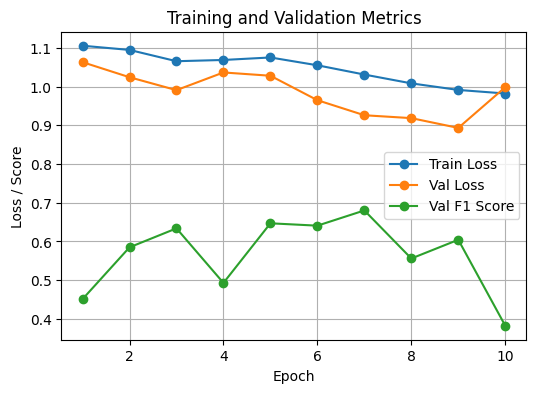

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_f1_scores, marker="o")
plt.title("Training and Validation Metrics")
plt.legend(["Train Loss", "Val Loss", "Val F1 Score"])
plt.xlabel("Epoch")
plt.ylabel("Loss / Score")
plt.grid(True)
plt.show()


### Cross-Validation with the `evaluate` Function (DCRNN)

The `evaluate` function is used to perform 5-fold cross-validation on the DCRNN model, providing a robust estimate of its generalization performance.

As with the CNN setup, the evaluation ensures that clips from the same patient are not split across training and validation sets—avoiding data leakage and preserving subject independence.

For each fold:
- A new instance of the `DCRNN` model is created with:
  - Graph-aware temporal modeling (using `A_forward` and `A_backward`)
  - Diffusion step `K = 3`
  - Single DCGRU layer and hidden dimension size of 64
- The model is trained for 5 epochs using:
  - Adam optimizer with learning rate `1e-3`
  - Weighted binary cross-entropy loss (`pos_weight = 4`) to address class imbalance
  - FFT-based signal preprocessing (`fft_filtering`) applied consistently

After training:
- Macro F1 score is computed for each fold.
- The function returns the average and standard deviation of F1 scores across folds, capturing both accuracy and stability of the model.

This modular setup allows easy experimentation with model architectures, transforms, and training hyperparameters while maintaining evaluation rigor.


In [ ]:
from evaluation import evaluate
from pathlib import Path

data_path = "../data"
DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

class_weight = 4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))

evaluate(
    DCRNN,
    clips_tr,
    signals_root=DATA_ROOT / "train",
    num_epochs=5,
    learning_rate=1e-3,
    model_args={
        "num_nodes": adj.shape[0],  # number of electrodes
        "input_dim": 1,
        "hidden_dim": 64,
        "output_dim": 1,
        "K": 3,
        "num_layers": 1,
        "A_forward": A_forward,      
        "A_backward": A_backward       
    },
    criterion=criterion,
    signal_transform=fft_filtering,
    batch_size=512,
    prefetch=True,
)


Fold 1/5
Fold 1 F1 Score: 0.6398
Fold 2/5
Fold 2 F1 Score: 0.5215
Fold 3/5
Fold 3 F1 Score: 0.6061
Fold 4/5
Fold 4 F1 Score: 0.5573
Fold 5/5
Fold 5 F1 Score: 0.5867
Cross-Validation Average F1 Score: 0.5823
Cross-Validation F1 Score Standard Deviation: 0.0405


(np.float64(0.5822807660787992), np.float64(0.040523330184073135))

# Submission

### Final Training and Test-Time Inference (DCRNN)

After validating the DCRNN model via cross-validation, we retrain it on the entire training dataset to take advantage of all available labeled data.

- The same preprocessing (`fft_filtering`), batch size (512), and weighted loss function are used.
- The model is trained for 10 epochs using the Adam optimizer with a learning rate of `1e-3`.
- Once training is complete, the model’s parameters are saved to `best_model_dcrnn.pth` for later use.

#### Inference Phase:
- Test clips are loaded and preprocessed using the same configuration as training, with `return_id=True` to collect sample IDs for submission.
- The trained model is re-instantiated and its parameters are loaded from the saved `.pth` file.
- During inference:
  - The model outputs logits for each EEG node.
  - These logits are averaged across nodes to produce a single prediction per sample.
  - Predictions are thresholded at 0 to match the `BCEWithLogitsLoss` behavior and converted into binary labels.

#### Submission:
- The predictions are paired with their corresponding IDs and saved in the required format.
- The final CSV file, `submission_dcrnn.csv`, contains two columns: `id` and `label`.

This process ensures that test-time inference is consistent with training, and that predictions are properly formatted for downstream evaluation or competition submission.


In [ ]:
DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,
)

loader_tr = DataLoader(dataset_tr, batch_size=512, shuffle=True)

model = DCRNN(
    num_nodes=adj.shape[0],
    input_dim=1,
    hidden_dim=64,
    output_dim=1,
    K=3,
    num_layers=1,
    A_forward=A_forward,
    A_backward=A_backward
).to(device)

class_weight = 4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  

num_epochs = 10
model.train()

for epoch in tqdm(range(num_epochs), desc="Training"):
    for x_batch, y_batch in loader_tr:
        x_batch = x_batch.float().unsqueeze(-1).to(device)   
        y_batch = y_batch.float().unsqueeze(-1).to(device)   

        optimizer.zero_grad()
        logits = model(x_batch)            

        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

# Save model
torch.save(model.state_dict(), "best_model_dcrnn.pth")
print("Model saved to best_model_dcrnn.pth")



Training: 100%|██████████████████████████████████████████████████| 10/10 [07:23<00:00, 44.32s/it]

Model saved to best_model_dcrnn.pth


In [18]:
# Load test clips
test_clips = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

# Create test dataset
dataset_te = EEGDataset(
    test_clips,
    signals_root=DATA_ROOT / "test",
    signal_transform=fft_filtering,
    prefetch=True,
    return_id=True  # Needed to include sample IDs
)

# Create DataLoader
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

model.load_state_dict(torch.load("best_model_dcrnn.pth"))

model.eval()

# Inference
all_predictions = []
all_ids = []

with torch.no_grad():
    for x_batch, ids in loader_te:
        x_batch = x_batch.float().unsqueeze(-1).to(device)  

        logits = model(x_batch)      
        logits = logits.mean(dim=1)  

        preds = (logits > 0).int().cpu().numpy()  # Threshold at 0 for BCEWithLogitsLoss
        all_predictions.extend(preds.flatten().tolist())
        all_ids.extend(ids)

# Build submission DataFrame
submission_df = pd.DataFrame({
    "id": all_ids,
    "label": all_predictions
})

# Save to CSV
submission_df.to_csv("submission_dcrnn.csv", index=False)
print("Submission file saved as submission_dcrnn.csv")


Submission file saved as submission_dcrnn.csv
